In [ ]:
# !pip install torchtext==0.6.0
# !pip install sudachipy sudachidict_core
# !pip install spacy[ja]
# !pip install spacy download en_core_web_sm

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
import math
import copy
from datetime import datetime
from nltk.translate.bleu_score import sentence_bleu
# from janome.tokenizer import Tokenizer

if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


/opt/conda/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [5]:
anki_dataset_df = pd.read_csv('eng_jpn.txt',sep='\t',names=['Japanese','English']) 
kyoto_lexicon_df = pd.read_csv('kyoto_lexicon.csv',on_bad_lines='skip')

In [6]:
anki_dataset_df.columns

Index(['Japanese', 'English'], dtype='object')

In [7]:
anki_dataset_df.head(10)

,Japanese,English
0,行け。,Go.
1,行きなさい。,Go.
2,こんにちは。,Hi.
3,もしもし。,Hi.
4,やっほー。,Hi.
5,こんにちは！,Hi.
6,走れ！,Run!
7,走れ。,Run.
8,走って！,Run.
9,誰？,Who?


In [8]:
len(anki_dataset_df['English'])

62487

In [9]:
len(anki_dataset_df['Japanese'])

62487

In [10]:
anki_dataset_df.dropna(inplace=True)

In [11]:
kyoto_lexicon_df.columns

Index(['日本語', '英語', 'Unnamed: 2'], dtype='object')

In [12]:
kyoto_lexicon_df.head(10)

,日本語,英語,Unnamed: 2
0,102世吉田日厚貫首,"the 102nd head priest, Nikko TOSHIDA",NaN
1,1月15日：成人祭、新年祭,"15th January: Seijin-sai (Adult Festival), the...",NaN
2,1月3日：家運隆盛、商売繁盛祈願祭,3rd January: Prayer Festival for the prosperit...,NaN
3,1月7日：七種粥神事,7th January: Nanakusa-gayu shinji (a divine se...,NaN
4,21世紀COEプログラム,The 21st Century Center Of Excellence Program,NaN
5,21世紀出陣弁当,"21-seiki Shutsujin Bento (21st century ""kick-o...",NaN
6,2月15日：初卯祭,15th February: Hatsuu-sai or The Rite of the F...,NaN
7,2代将軍足利義詮,the Second Shogun Yoshiakira ASHIKAGA,NaN
8,305世中村日玄貫首,the 305th chief priest Nichigan NAKAMURA,NaN
9,32世済範入道親王,the 32nd priestly Imperial Prince Saihan,NaN


In [13]:
kyoto_lexicon_df = kyoto_lexicon_df[['日本語', '英語']]
kyoto_lexicon_df.columns = ['Japanese', 'English']

In [14]:
kyoto_lexicon_df.dropna(inplace=True)

In [15]:
JA = spacy.blank('ja')
EN = spacy.load("en_core_web_sm")

In [16]:
def tokenize_ja(sentence):
    return [tok.text for tok in JA.tokenizer(sentence)]

def tokenize_en(sentence):
    return [tok.text for tok in EN.tokenizer(sentence)]

In [17]:
JA_TEXT = Field(tokenize=tokenize_ja) 
EN_TEXT = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>') 

In [18]:
frames = [anki_dataset_df, kyoto_lexicon_df]

In [19]:
merged_dataset_df = pd.concat(frames)

In [20]:
merged_dataset_df.head()

,Japanese,English
0,行け。,Go.
1,行きなさい。,Go.
2,こんにちは。,Hi.
3,もしもし。,Hi.
4,やっほー。,Hi.


In [21]:
len(merged_dataset_df["Japanese"])

114458

In [ ]:
train, val, test = np.split(merged_dataset_df.sample(frac=1), [int(.6*len(merged_dataset_df)), int(.8*len(merged_dataset_df))]) 
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False) 
test.to_csv('test.csv', index=False)

In [24]:
data_fields = [('Japanese', JA_TEXT), ('English', EN_TEXT)]
train, val, test = TabularDataset.splits(path='./',train='train.csv',validation='val.csv',test = 'test.csv',format='csv',fields = data_fields )

In [25]:
JA_TEXT.build_vocab(train, val) 
EN_TEXT.build_vocab(train, val) 

In [26]:
BATCH_SIZE = 20
EPOCHS = 100

D_MODEL = 512
HEADS = 8
N = 6

In [27]:
train_iter = BucketIterator(train,batch_size=BATCH_SIZE,sort_key=lambda x: len(x.English),shuffle=True)

In [28]:
batch = next(iter(train_iter)) 
print(batch.English)

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2],
        [  675,   267,  7639,    13,  1070,    21,    21,  4335,   436,   381,
          6357, 35746,  6227,    73,   686,  9385,    21,    55,     5,  4253],
        [  257,    94,     9,   177,   152,    20,  2203,     3,   640,    13,
           436,     3, 33969,  1180,  1209,     9,  3960,     8,    38,  6714],
        [    4,  1838,   834,    25,     6,     8,   540,     1,  2393, 16751,
             3,     1,    19, 33270,    10,  6619,    67,   324,  3959,     3],
        [    5,     6,   610,    44,  1595,   329,     7,     1,    19,    11,
             1,     1,   618,    69,  1237,    19,   696,   173,     4,     1],
        [   66,   352,     3,   741,     4,   278,  1167,     1,   855,     3,
             1,     1,    18,  1449,  1069,   328,     4,   133,     3,     1],
        [    7,    23,     1,   364,     3,   

In [29]:
print(batch.Japanese) 

tensor([[ 2542,    33, 26462,    10,  1991,  2876,    14,  5462,   498,    10,
          9783, 21133,  4327,    67,  3779,   426,    14,   274,    15,  2359],
        [   13,   445,     1,     3,     7,    47,     3,     1,   428,     3,
         34321,     1,   546,     4,  1065,  1817,     3,   626,     3,  2628],
        [  511,     9,     1,    46,   925,    21,  2948,     1,   869,  4430,
             1,     1,     1,   200,   757,   465,    29,   285,   914,     1],
        [   25,  8908,     1,     5,    89,     2,     5,     1,     1,    71,
             1,     1,     1,     3,  4747,   566,     4,    28,     9,     1],
        [   17,     5,     1,  6961,     2,     1,   873,     1,     1,     6,
             1,     1,     1,    58,  2550,     1,  1399,     4,    55,     1],
        [ 1168,  1121,     1,     4,     1,     1,     5,     1,     1,     4,
             1,     1,     1,    20,  6269,     1,     7,  1138,    21,     1],
        [    5,   179,     1,   637,     1,   

In [30]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.Japanese))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.English) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

In [31]:
train_iter = MyIterator(
    train,
    batch_size=1300,
    device=0,
    repeat=False,
    sort_key=lambda x: (len(x.Japanese), len(x.English)),
    batch_size_fn=batch_size_fn,
    train=True,
    shuffle=True
)

In [32]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        # print("inside embedder init")
        super(Embedder, self).__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        # print("inside embedder forward")
        return self.embed(x)

In [33]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        # print("inside PositionalEncoder init")
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # print("inside PositionalEncoder forward")
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False).to(device)
        # print(x)
        return x

In [34]:
def create_masks(input_seq, target_seq):
    # print("inside create_masks")
    input_pad = JA_TEXT.vocab.stoi['<pad>']
    # creates mask with 0s wherever there is padding in the input
    input_msk = (input_seq != input_pad).unsqueeze(1)
    
    target_pad = EN_TEXT.vocab.stoi['<pad>']
    target_msk = (target_seq != target_pad).unsqueeze(1)
    size = target_seq.size(1) # get seq_len for matrix
    nopeak_mask = np.triu(np.ones((1, size, size)), k=1).astype(np.uint8)
    nopeak_mask = torch.autograd.Variable(torch.from_numpy(nopeak_mask) == 0).to(device)
    target_msk = target_msk & nopeak_mask
    
    # print(input_msk)
    # print(target_msk)
    return input_msk, target_msk

In [35]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    # print("inside attention")
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    # print(scores)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    # print(output)
    return output

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        # print("inside MultiHeadAttention __init__")
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # print("inside MultiHeadAttention forward")
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        # print(output)
        return output

In [37]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        # print("inside FeedForward init")
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) 
    def forward(self, x):
        # print("inside FeedForward forward")
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        # print(x)
        return x

In [38]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        # print("inside Norm init")
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        # print("inside Norm forward")
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        # print(norm)
        return norm

In [39]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        # print("inside EncoderLayer init")
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # print("inside EncoderLayer forward")
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        # print("inside EncoderLayer forward : "+x)
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        # print("inside EncoderLayer __init__")
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).to(device)

    def forward(self, x, e_outputs, src_mask, trg_mask):
            # print("inside EncoderLayer forward")
            x2 = self.norm_1(x)
            x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
            x2 = self.norm_2(x)
            x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
            src_mask))
            x2 = self.norm_3(x)
            x = x + self.dropout_3(self.ff(x2))
            # print(x)
            return x

# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [40]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        # print("inside Encoder __init__")
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        # print("inside Encoder forward")
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        # print("inside Decoder __init__")
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        # print("inside Decoder forward")
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [41]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        # print("inside Transformer __init__")
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        # print("inside Transformer forward")
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

In [42]:
src_vocab = len(JA_TEXT.vocab)
trg_vocab = len(EN_TEXT.vocab)
# print(JA_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, D_MODEL, N, HEADS)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [43]:
input_pad = JA_TEXT.vocab.stoi['<pad>']
target_pad = EN_TEXT.vocab.stoi['<pad>'] 

In [44]:
MultiHeadAttention(HEADS, D_MODEL)

MultiHeadAttention(
  (q_linear): Linear(in_features=512, out_features=512, bias=True)
  (v_linear): Linear(in_features=512, out_features=512, bias=True)
  (k_linear): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=512, out_features=512, bias=True)
)

In [45]:
Loss_hist = []
Perplexity_hist = []
def train_model(model, epochs, print_every=50):
    
    model.train()
    
    start = datetime.now()
    temp = start
    
    total_loss = 0
    
    for epoch in range(epochs):
       
        for i, batch in enumerate(train_iter):
            src = batch.Japanese.transpose(0, 1)
            trg = batch.English.transpose(0, 1)
            # the French sentence we input has all words except
            # the last, as it is using each word to predict the next
            
            trg_input = trg[:, :-1]
            
            # the words we are trying to predict
            
            targets = trg[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            loss = F.cross_entropy(
                preds.view(-1, preds.size(-1)),
                targets,
                ignore_index=target_pad
            )
            loss.backward()
            optim.step()
            
            total_loss += loss.item()
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                perplexity  = math.exp(loss_avg)
                print("time = {}, epoch {}, iter = {}, loss = {}, perplexity = {}, {} per {} iters".format(
                    (datetime.now() - start) // 60,
                    epoch + 1,
                    i + 1,
                    loss_avg,
                    perplexity,
                    datetime.now() - temp,
                    print_every
                ))
                if i+1 == 450:
                    Loss_hist.append(loss_avg)
                    Perplexity_hist.append(perplexity)
                total_loss = 0
                temp = datetime.now()
    
        print()

In [46]:
model.to(device)
train_model(model, EPOCHS)

time = 0:00:00.162370, epoch 1, iter = 50, loss = 9.026400375366212, perplexity = 8319.857242928714, 0:00:09.742247 per 50 iters
time = 0:00:00.303936, epoch 1, iter = 100, loss = 7.2491365337371825, perplexity = 1406.889521945882, 0:00:08.493838 per 50 iters
time = 0:00:00.445294, epoch 1, iter = 150, loss = 6.561819610595703, perplexity = 707.5580039904867, 0:00:08.481364 per 50 iters
time = 0:00:00.588284, epoch 1, iter = 200, loss = 6.1191468429565425, perplexity = 454.47678897728576, 0:00:08.579299 per 50 iters
time = 0:00:00.732272, epoch 1, iter = 250, loss = 5.952044076919556, perplexity = 384.5385626596013, 0:00:08.639124 per 50 iters
time = 0:00:00.878640, epoch 1, iter = 300, loss = 5.64722861289978, perplexity = 283.50467487755805, 0:00:08.781940 per 50 iters
time = 0:00:01.022792, epoch 1, iter = 350, loss = 5.581177368164062, perplexity = 265.3838764487724, 0:00:08.648992 per 50 iters
time = 0:00:01.170805, epoch 1, iter = 400, loss = 5.464517831802368, perplexity = 236.1

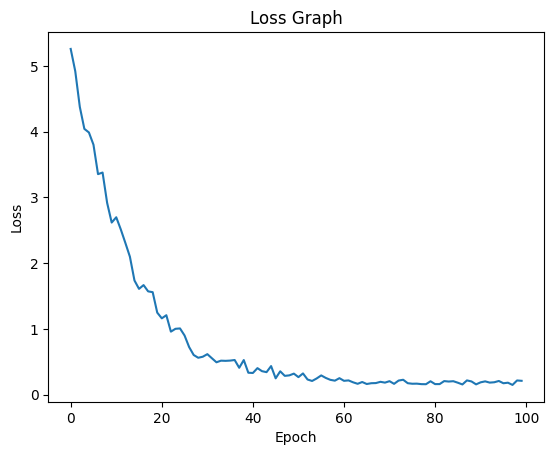

In [47]:
epoch = list(range(100))
import matplotlib.pyplot as plt
plt.plot(epoch,Loss_hist)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() 

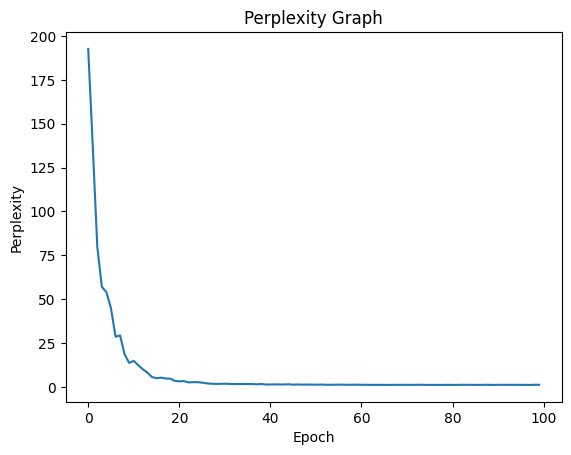

In [48]:
plt.plot(epoch ,Perplexity_hist)
plt.title('Perplexity Graph')
plt.xlabel('Epoch')
plt.ylabel('Perplexity') 
plt.show() 

In [49]:
def translate(model, src, max_len=80, custom_sentence=False):
    
    model.eval()
    
    if custom_sentence == True:
        src = tokenize_ja(src)
        src = torch.autograd.Variable(torch.LongTensor([[JA_TEXT.vocab.stoi[tok] for tok in src]])).to(device)
    
    src_mask = (src != input_pad).unsqueeze(-2)
    e_outputs = model.encoder(src, src_mask)

    outputs = torch.zeros(max_len).type_as(src.data)
    outputs[0] = torch.LongTensor([EN_TEXT.vocab.stoi['<sos>']])
    
    for i in range(1, max_len):    
        trg_mask = np.triu(np.ones((1, i, i)), k=1).astype('uint8')
        trg_mask = torch.autograd.Variable(torch.from_numpy(trg_mask) == 0).to(device)

        out = model.out(
            model.decoder(
                outputs[:i].unsqueeze(0),
                e_outputs,
                src_mask,
                trg_mask
            )
        )
        out = F.softmax(out, dim=-1)
        val, ix = out[:, -1].data.topk(1)

        outputs[i] = ix[0][0]
        if ix[0][0] == EN_TEXT.vocab.stoi['<eos>']:
            break

    return ' '.join([EN_TEXT.vocab.itos[ix] for ix in outputs[:i]])

In [50]:
translate(model, '僕は駅に行く途中なの', custom_sentence=True) 

'<sos> I am on my way to the station .'

In [51]:
translate(model, '日本語は難しいと思います', custom_sentence=True) 

'<sos> I think that Japanese is difficult .'

In [52]:
translate(model, '英語は簡単です' , custom_sentence=True)

'<sos> English is easy .'

In [53]:
test_df = pd.read_csv('test.csv') 

In [54]:
test_df

,Japanese,English
0,私が今出来るのは待つことだけだ。,All I can do is wait.
1,大内義興,Yoshioki OUCHI
2,言葉が口先まで出かかっているのだが、自分のいいたいことをどう表現したらいいのかよくわからない。,"The words are on the tip of my tongue, but I d..."
3,彼は大統領に選ばれた。,He was elected president.
4,なにか書くものをくれ。,Give me something to write with.
...,...,...
22887,彼女は時間がないといつも不平たらたらだ。,She keeps complaining that she doesn't have time.
22888,私は肉より魚の方が好きです。,I prefer fish to meat.
22889,この自転車、誰の？,Whose bike is this?
22890,今は外出したくない気分だ。,I don't feel like going out right now.


In [55]:
import warnings
warnings.filterwarnings('ignore') 

In [56]:
len(test_df)

22892

In [57]:
data_length = len(test_df["English"])
total_score = 0

for i in range(data_length):
    # print(i) if i % 1000==0 else None
    reference = tokenize_en(test_df["English"][i])
    candidate = tokenize_en(translate(model, test_df["Japanese"][i] , custom_sentence=True))
    candidate = candidate[3:]
    score = sentence_bleu(reference, candidate)
    total_score += score

In [58]:
print(f'BLEU score = {(total_score/data_length)}') 

BLEU score = 0.39995083315853797
